In [112]:
# import modules
import importlib
from pypet import Environment, Parameter, cartesian_product, progressbar, Trajectory
import numpy as np
import csv
import os
import copy
import pickle
import logging
from datetime import date
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')
import scipy
from fitnessinference import simulation as simu
from fitnessinference import analysis as ana

In [144]:
# run this to reload a module after editing it 
# (instead of restarting the whole notebook kernel):
importlib.reload(ana)

<module 'fitnessinference.analysis' from 'C:\\Users\\julia\\Documents\\Resources\\InfluenzaFitnessLandscape\\NewApproachFromMarch2021\\InfluenzaFitnessInference\\code\\notebooks\\fitnessinference\\analysis.py'>

In [118]:
# load data from one simulation:

result_directory = ('C:/Users/julia/Documents/Resources/InfluenzaFitnessLandscape/NewApproachFromMarch2021/'
                    'InfluenzaFitnessInference')
simu_name = '2021Apr07'
single_simu_filename =\
'running_N_pop_1e+06N_site_20N_state_2mu_1e-04sigma_h_1D0_5h_0_-7J_0_0seed_123456N_simu_2e+02.data'

strain_yearly, strain_frequency_yearly, traj =\
        ana.load_simu_data(single_simu_filename, simu_name, result_directory=result_directory)

# model fitness landscape
if traj.hJ_coeffs=='constant':
    h_model, J_model = simu.fitness_coeff_constant(traj.N_site, traj.N_state, traj.h_0, traj.J_0)
elif traj.hJ_coeffs=='p24':
    h_model, J_model = simu.fitness_coeff_p24(traj.N_site, traj.N_state)

In [4]:
# sampling and inference parameters

# number of sequences sampled from surviving strains
B = 10**4 
# RNG seed for sampling
seed_sample = 20390 
# generations to start and end inference
inf_start = 100 
inf_end = 200
# regularization coefficients for the three types of inferred parameters
# 0 means no regularization, 1 means unit variance
lambda_h = 0
lambda_J = 1
lambda_f = 0

In [16]:
# take random samples from each inference generation
strain_sample_yearly, strain_sample_count_yearly, strain_sample_frequency_yearly=\
    ana.sample_seqs(strain_yearly, strain_frequency_yearly, seed_sample, B, inf_end)

# calculate F_int for each time step between inf_start and inf_end
minus_fhost_yearly = [-simu.fitness_host_list(strain_sample_yearly[t], strain_sample_yearly[:t], 
                                              strain_sample_frequency_yearly[:t], traj.sigma_h, traj.D0)
                    for t in range(inf_start, inf_end)]

# calculate -F_host for each time step between inf_start and inf_end
fint_yearly = [simu.fitness_int_list(strain_sample_yearly[t], traj.N_state, h_model, J_model)
                    for t in range(inf_start, inf_end)]


In [90]:
# process data for inference (calculation of feature matrix X and output matrix Y)

# calculation of features matrix X
X = ana.inference_features_Ising(strain_sample_yearly[inf_start:inf_end])

# calculation of response vector Y
Y = ana.inference_response_FhostPrediction(minus_fhost_yearly)

# inference (parameter vector M and standard error M_std of inferred params):
M, M_std = ana.infer_ridge(X, Y, lambda_h, lambda_J, lambda_f, inf_start, inf_end)

In [154]:
# compare model fitness coeffs against inferred coeffs

# model coefficients
h_model_list, J_model_list, hJ_model_list = ana.hJ_model_lists(h_model, J_model)
# inferred coefficients
h_inf_list, J_inf_list, hJ_inf_list = ana.hJ_inf_lists(M, traj.N_site)
# std of inferred coefficients
std_h_inf_list, std_J_inf_list, std_hJ_inf_list = ana.hJ_inf_std_lists(M_std, traj.N_site)

rho, pval=scipy.stats.pearsonr(h_model_list, h_inf_list) # spearman rank correlation
print('linear correlation for h: rho=',rho,', p=',pval)
rho, pval=scipy.stats.pearsonr(J_model_list, J_inf_list) # spearman rank correlation
print('linear correlation for J: rho=',rho,', p=',pval)
rho, pval=scipy.stats.pearsonr(hJ_model_list, hJ_inf_list) # spearman rank correlation
print('linear correlation for hi+hj+Jij: rho=',rho,', p=',pval)

linear correlation for h: rho= 0.9323809990080677 , p= 2.1924232419110587e-09
linear correlation for J: rho= 0.6675947329371585 , p= 7.08374694068989e-26
linear correlation for hi+hj+Jij: rho= 0.9435848095678334 , p= 3.541438985421108e-92


linear correlation for h: rho= 0.9323809990080677 , p= 2.1924232419110587e-09
linear correlation for J: rho= 0.6675947329371585 , p= 7.08374694068989e-26
linear correlation for hi+hj+Jij: rho= 0.9435848095678334 , p= 3.541438985421108e-92


Spearman rank correlation for h: rho= 0.9278195488721804 , p= 3.879148683992122e-09
Spearman rank correlation for J: rho= 0.41555459328950656 , p= 2.4908601332725426e-09
Spearman rank correlation for hi+hj+Jij: rho= 0.9381542862391582 , p= 1.5463439337493642e-88


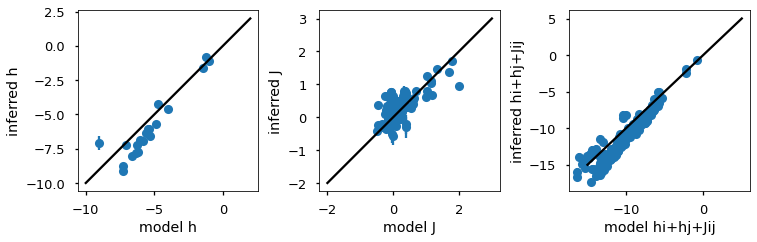

<Figure size 748.8x514.8 with 0 Axes>

<Figure size 748.8x514.8 with 0 Axes>

<Figure size 748.8x514.8 with 0 Axes>

In [155]:
N_site = traj.N_site

h_epi_model,J_epi_model,hJ_epi_model=hJ_redlist_fromlist(h_model, J_model, N_site, 0) # model params
h_epi_inf,J_epi_inf,hJ_epi_inf,f_inf=coeffs_inf_reduced(M,inf_start,inf_end,N_site,0) # inferred params
h_epi_std,J_epi_std,hJ_epi_std,f_std=coeffs_std_reduced(M_std,inf_start,inf_end,N_site,0)

## comparison of inferred and model coefficients in one figure with 3 panels:
fig, ((ax1,ax2,ax3)) = plt.subplots(1, 3, constrained_layout=True)
# subplot for h comparison
x=np.linspace(-10,2,num=2)
fig=plt.figure()
ax1.errorbar(h_epi_model,h_epi_inf,h_epi_std,marker='o',linestyle='none',zorder=1)
ax1.plot(x,x,'-',color='black')
ax1.set(xlabel='model h')
ax1.set(ylabel='inferred h')
ax1.set_aspect(1/ax1.get_data_ratio())
# subplot for J comparison
x=np.linspace(-2,3,num=2)
fig=plt.figure()
ax2.errorbar(J_epi_model,J_epi_inf,J_epi_std,marker='o',linestyle='none',zorder=1)
#plt.plot(J_model[1327],M[num_h+1327],marker='o',linestyle='none',color='yellow',zorder=2)
#plt.plot(J_model[113],M[num_h+113],marker='o',linestyle='none',color='red',zorder=2)
ax2.plot(x,x,'-',color='black')
ax2.set(xlabel='model J')
ax2.set(ylabel='inferred J')
ax2.set_aspect(1/ax2.get_data_ratio())
# subplot for hi+hj+Jij comparison
x=np.linspace(-15,5,num=2)
fig=plt.figure()
ax3.errorbar(hJ_epi_model,hJ_epi_inf,hJ_epi_std,marker='o',linestyle='none',zorder=1)
ax3.plot(x,x,'-',color='black')
ax3.set(xlabel='model hi+hj+Jij')
ax3.set(ylabel='inferred hi+hj+Jij')
ax3.set_aspect(1/ax3.get_data_ratio())

# # plot for f(t):
# fig=plt.figure()
# plt.errorbar(np.arange(len(f_inf)),f_inf,f_std,marker='o',linestyle='none',zorder=1)
# plt.xlabel('inference generation')
# plt.ylabel('inferred f(t)')
# plt.show()
# plt.close()


rho, pval=scipy.stats.pearsonr(h_epi_model.flatten(),h_epi_inf) # spearman rank correlation
print('linear correlation for h: rho=',rho,', p=',pval)
rho, pval=scipy.stats.pearsonr(np.array(J_epi_model).flatten(),J_epi_inf) # spearman rank correlation
print('linear correlation for J: rho=',rho,', p=',pval)
rho, pval=scipy.stats.pearsonr(np.array(hJ_epi_model).flatten(),hJ_epi_inf) # spearman rank correlation
print('linear correlation for hi+hj+Jij: rho=',rho,', p=',pval)

print('\n')

rho, pval=scipy.stats.spearmanr(h_epi_model,h_epi_inf) # spearman rank correlation
print('Spearman rank correlation for h: rho=',rho,', p=',pval)
rho, pval=scipy.stats.spearmanr(np.array(J_epi_model).flatten(),J_epi_inf) # spearman rank correlation
print('Spearman rank correlation for J: rho=',rho,', p=',pval)
rho, pval=scipy.stats.spearmanr(np.array(hJ_epi_model).flatten(),hJ_epi_inf) # spearman rank correlation
print('Spearman rank correlation for hi+hj+Jij: rho=',rho,', p=',pval)

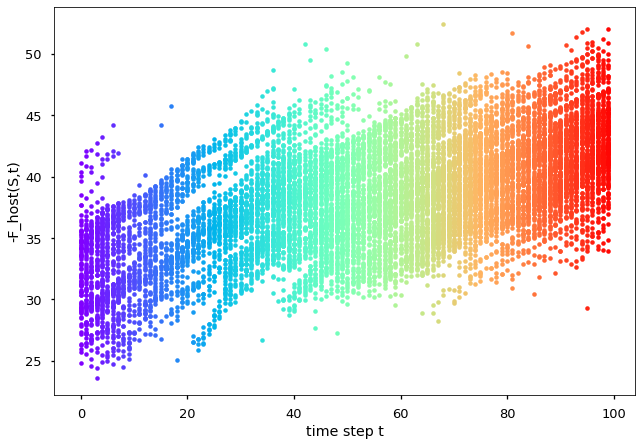

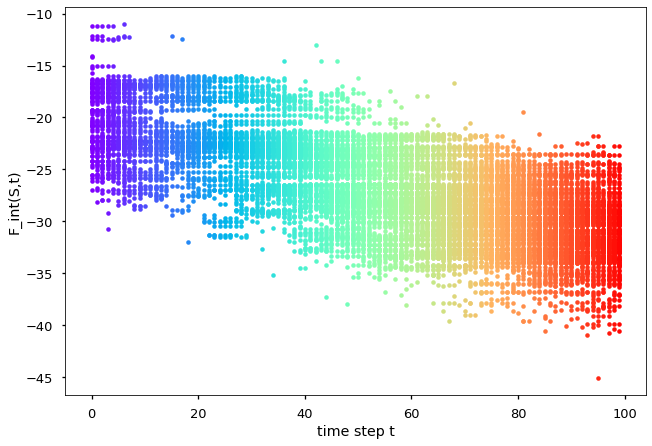

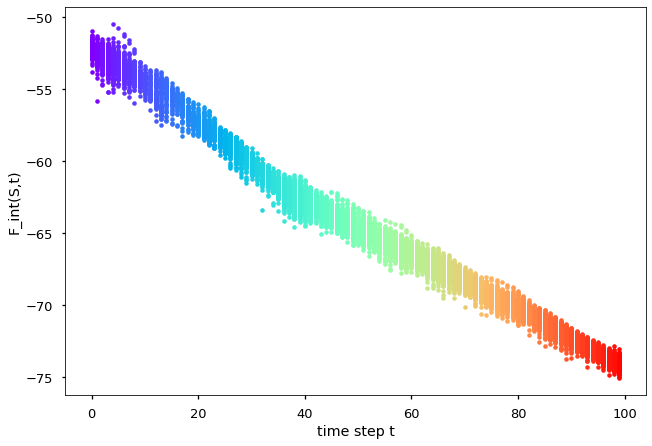

mean std of F_host:  3.5730964063916004
mean std of F_int:  3.5124143034636206
mean std of F_tot:  0.5118483655930227


In [21]:
# plot the data and fitnesses 
cm = plt.get_cmap('rainbow')
colorlist=list(cm(1.*i/(len(minus_fhost_yearly))) for i in range(len(minus_fhost_yearly)))

# -F_host
figure=plt.figure()
for t in range(len(minus_fhost_yearly)):
    plt.plot([t]*len(minus_fhost_yearly[t]), minus_fhost_yearly[t],'.',color=colorlist[t])
plt.xlabel('time step t')
plt.ylabel('-F_host(S,t)')
#plt.ylim([-10,60])
plt.show()
plt.close()

# F_int
figure=plt.figure()
for t in range(len(fint_yearly)):
    plt.plot([t]*len(fint_yearly[t]), fint_yearly[t],'.',color=colorlist[t])
plt.xlabel('time step t')
plt.ylabel('F_int(S,t)')
#plt.ylim([-10,60])
plt.show()
plt.close()

ftot_yearly = [[fint_yearly[t][i] - minus_fhost_yearly[t][i] for i in range(len(minus_fhost_yearly[t]))] 
               for t in range(len(minus_fhost_yearly))]
# F_tot
figure=plt.figure()
for t in range(len(fint_yearly)):
    plt.plot([t]*len(ftot_yearly[t]), ftot_yearly[t],'.',color=colorlist[t])
plt.xlabel('time step t')
plt.ylabel('F_int(S,t)')
#plt.ylim([-10,60])
plt.show()
plt.close()

# mean std of fitnesses:
f_host_std = np.mean([np.std(fs) for fs in minus_fhost_yearly])
f_int_std = np.mean([np.std(fs) for fs in fint_yearly])
f_tot_std = np.mean([np.std(fs) for fs in ftot_yearly])
print('mean std of F_host: ', f_host_std)
print('mean std of F_int: ', f_int_std)
print('mean std of F_tot: ', f_tot_std)